In [1]:
%env CUDA_VISIBLE_DEVICES=0
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

import warnings
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, Dense, Lambda, merge, Conv2D, LocallyConnected2D
from keras.layers import MaxPooling2D, Reshape, UpSampling2D, Conv2DTranspose
from keras.layers import AveragePooling2D, LeakyReLU, ZeroPadding2D, Dropout
from keras.models import Model, load_model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.objectives import mean_squared_error, kullback_leibler_divergence
from keras.objectives import categorical_crossentropy
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops
import time
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from model import fcn_vae
from parameters import fcn_parameters
from callbacks import setup_kl_callback

env: CUDA_VISIBLE_DEVICES=0


Using TensorFlow backend.


In [2]:
n_steps = 50      # similar to number of MD configurations
n_atoms = 1200    # atoms
n_coords = 3      # 3D: x, y, z
hidden_dim = 150  # latent space dim
batch_size = 10   

xyz = np.random.random((n_steps, n_atoms, n_coords))
dismat = np.array([ distance_matrix(i, i) for i in xyz ])
y_true = np.zeros((n_steps, hidden_dim*2))
dismat.shape

(50, 1200, 1200)

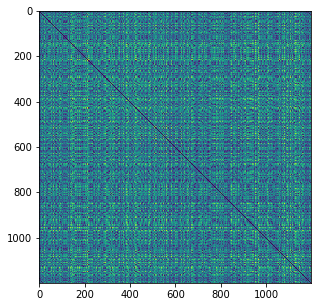

In [3]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(dismat[0], interpolation='nearest')

In [4]:
p = fcn_parameters()
params = p.parse_args(['--NCHARS=1200',
                       '--MAX-LEN=1200',
                       '--hidden-dim=%d'%hidden_dim,
                       '--dec-filters=1200',
                       '--dec-reslayers=3',
                       '--batch-size=%d'%batch_size,
                       '--optimizer=adam'
                      ])
params

Namespace(MAX_LEN=1200, NCHARS=1200, activation='relu', batch_size=10, checkpoint_path='/tmp', checkpoint_period=0, dec_filter_growth_fac=1.0, dec_filters=1200, dec_kernel_size=5, dec_reslayers=3, decoder_sampling_temperature=0.0, do_prop_pred=False, enable_tensorboard=False, enc_kernel_size=5, epochs=1500, hc_penalty_path='', hc_scale_fac=240.0, hdf5_file_path='/projects/data/production.h5', hidden_dim=150, kl_distribution_width=1.0, kl_final_ramp=30, kl_loss_weight=0.03, kl_start_ramp=10, learning_rate=1e-05, lr_schedule_cooldown=0, lr_schedule_min=0.0, lr_schedule_patience=0, lr_schedule_prop='val_loss', optimizer='adam', overwrite_checkpoint=False, previous_epochs=0, profile=False, profile_filename='timeline.tGRU.json', prop_activation='relu', prop_add=None, prop_conv_layers=3, prop_dense_layer_size=256, prop_dense_layers=3, prop_dropout_prob=0.0, prop_growth_factor=1.5, prop_kernel_size=5, prop_pred_final_ramp=4000, prop_pred_initial_weight=0.0, prop_pred_start_ramp=50, prop_pred_

In [5]:
#-------------------------------- optimizer -----------------------------------#
if params.optimizer=='adam':
    params.optimizer = Adam(lr=params.learning_rate)
elif params.optimizer=='sgd':
    params.optimizer = SGD(lr=params.learning_rate)

In [6]:
model, encoder, decoder, prop_pred = fcn_vae(params)

In [8]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_smiles (InputLayer)       (None, 1200, 1200)   0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1200, 1200)   7201200     input_smiles[0][0]               
__________________________________________________________________________________________________
res0_bn1 (BatchNormalization)   (None, 1200, 1200)   4800        conv1d_1[0][0]                   
__________________________________________________________________________________________________
res0_act1 (Activation)          (None, 1200, 1200)   0           res0_bn1[0][0]                   
____________________________________________________________________________________________

In [9]:
kl_loss_var, kl_callback = setup_kl_callback(params)

def KL_loss(y_true, mu_l_sigma_output):
    mu, l_sigma = tf.split(mu_l_sigma_output, 2, axis=1)
    KL = -0.5 * K.mean(1 + l_sigma - K.square(mu) - K.exp(l_sigma), axis=-1)
    return KL

def recon_loss(y_true, y_pred):
    #return categorical_crossentropy(y_true, y_pred)
    return mean_squared_error(y_true, y_pred)


model_losses = [ recon_loss, KL_loss ]

loss_weights = [ 1.0, 0.01 ]

#------------------------------- metrics --------------------------------------#
# metric functions to track annealing variables
def kl_weight_anneal(y_true, y_pred): return kl_loss_var
def  reg_prop_anneal(y_true, y_pred): return prop_pred_var

metrics={'x_pred': ['categorical_accuracy', kl_weight_anneal]}

#----------------------------- model compile ----------------------------------#
model.compile(loss=model_losses,
              loss_weights=loss_weights,
              metrics=metrics,
              optimizer=params.optimizer)

In [10]:
model.fit(x=dismat,
          y=[dismat, y_true],
          batch_size=batch_size,
          epochs=10,
          callbacks=[],
          verbose=True)

Epoch 1/10
50/50 [==============================] - 12s 244ms/step - loss: 0.4961 - x_pred_loss: 0.4933 - z_mean_log_var_loss: 0.2749 - x_pred_categorical_accuracy: 7.8333e-04 - x_pred_kl_weight_anneal: 0.0300
Epoch 2/10
50/50 [==============================] - 3s 60ms/step - loss: 0.4064 - x_pred_loss: 0.4037 - z_mean_log_var_loss: 0.2636 - x_pred_categorical_accuracy: 9.6667e-04 - x_pred_kl_weight_anneal: 0.0300
Epoch 3/10
50/50 [==============================] - 3s 60ms/step - loss: 0.3814 - x_pred_loss: 0.3789 - z_mean_log_var_loss: 0.2425 - x_pred_categorical_accuracy: 8.0000e-04 - x_pred_kl_weight_anneal: 0.0300
Epoch 4/10
50/50 [==============================] - 3s 60ms/step - loss: 0.3597 - x_pred_loss: 0.3574 - z_mean_log_var_loss: 0.2363 - x_pred_categorical_accuracy: 9.0000e-04 - x_pred_kl_weight_anneal: 0.0300
Epoch 5/10
50/50 [==============================] - 3s 60ms/step - loss: 0.3410 - x_pred_loss: 0.3386 - z_mean_log_var_loss: 0.2432 - x_pred_categorical_accuracy: 6.0